In [15]:
import requests
import json
import os
import numpy as np
from os.path import join
from typing import Tuple, List, Dict, Union, Set
from time import sleep

In [16]:
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm

In [17]:
api_url = 'http://45.14.48.80:10000/'
upload_url = api_url + 'upload'
task_url = api_url + 'task'
healthcheck_url = api_url + 'healthcheck'
results_url = api_url + 'results'

CURL_POST = 'curl -vvvv -X POST'
CURL_GET = 'curl -vvvv -X GET'

cwd = os.getcwd()
models_path = 'data/models'

In [18]:
def upload(full_path: str, upload_url: str) -> Tuple[str, str]:
    r = json.loads(os.popen(f'{CURL_POST} -H "User-Id: test" --form file="@{full_path}" "{upload_url}"').read())
    uuid = r['uuid']
    filename = r['filename']
    return uuid, filename

def task(uuid: str, filename: str, task_url: str):
    config = {
        'uuid' : uuid,
        'verison': '1',
        'file': filename,
        'id': 'test',
        'is_part': False
    }
    config = json.dumps(config)
    os.popen(f'{CURL_POST} -d \'{config}\' "{task_url}"').read()
    
def healthcheck(healthcheck_url: str) -> Tuple[str, str]:
    r = json.loads(os.popen(f'{CURL_GET} "{healthcheck_url}"').read())
    return r['status'], r['progress']

def get_bins_number_set(results_url: str) -> Set[int]:
    r = json.loads(os.popen(f'{CURL_GET} "{results_url}"').read())['histogram_data']
    return set([el['intervals'] for el in r if not el['type'].startswith('hull')])

def get_hists(bins_num: int, results_url: str) -> Dict[str,  List[float]]:
    r = json.loads(os.popen(f'{CURL_GET} "{results_url}"').read())['histogram_data']
    hists = [el for el in r if (el['intervals'] == bins_num) and not el['type'].startswith('hull')]
    res = {}
    for el in hists: 
        res[el['type']] = el['data']
    
    return res

In [19]:
models_lst = [el for el in os.listdir(models_path) if el.endswith('.stl')]
models_lst[:2]

['eea8de8c-071c-40a9-b890-51c786838889.stl',
 '4de1f31b-9dc8-4eb7-987a-19caf8ad70ca.stl']

In [20]:
i = 0
full_path = f'{cwd}/{models_path}/{models_lst[i]}'
uuid, filename = upload(full_path, upload_url)
task(uuid, filename, task_url)

pbar = tqdm(total=100)
status, progress = healthcheck(healthcheck_url)
while status != 'COMPLETED':
    status, progress = healthcheck(healthcheck_url)
    pbar.update(round(progress - pbar.n))
    sleep(1)

In [22]:
get_bins_number_set(results_url)

{8, 16, 32, 64, 128}

In [13]:
hists = get_hists(64, results_url)

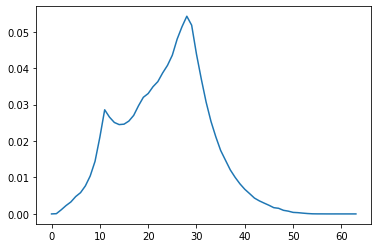

In [14]:
plt.plot(hists['model_bounding_sphere_strict_outer']);